In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset
from nilearn.connectome import sym_matrix_to_vec
from ContModeling.helper_classes import MatData
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.cross_decomposition import CCA
from sklearn.metrics import mean_absolute_percentage_error



In [72]:
root = '.'
train_ratio = 1.0
test_ratio = 0.3

## Functions to plot


In [73]:
def plot_scores(ridge, cca, model, targets, model_and_ridge=None):
    ridge = ridge.assign(model="Ridge")
    cca = cca.assign(model="CCA")
    model = model.assign(model="Contrastive learning")
    if model_and_ridge is not None:
        model_and_ridge = model_and_ridge.assign(model="Contrastive learning and Ridge regression")

    # Concatenate results
    if model_and_ridge is not None and not model_and_ridge.empty:
        primary_model = model_and_ridge
        all_results = pd.concat([ridge, cca, model, model_and_ridge], ignore_index=True)
    else:
        primary_model = model
        all_results = pd.concat([ridge, cca, model], ignore_index=True)

    # Compute Spearman correlation and MAPE for each target in the test set
    results = []
    for model_name, group in all_results.groupby("model"):
        test_data = group[group["dataset"] == "test"]

        for target in targets:
            if target in test_data.columns:
                true_values = test_data[target]
                predicted_values = test_data[f"{target}_pred"]

                # Avoid issues with empty or NaN values
                if not true_values.isna().all() and not predicted_values.isna().all():
                    # Spearman correlation
                    spearman_corr = spearmanr(true_values, predicted_values)[0]
                    # MAPE (Mean Absolute Percentage Error)
                    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

                    results.append(
                        {"model": model_name, "target": target, "spearman_corr": spearman_corr, "mape": mape}
                    )

    results_df = pd.DataFrame(results)

    # Filter results for the primary model to determine ranking
    primary_results = results_df[results_df["model"] == primary_model["model"].iloc[0]]

    # Rank targets based on Spearman and MAPE for the primary model
    target_ranking = (
        primary_results[["target", "spearman_corr", "mape"]]
        .assign(
            spearman_corr_rank=lambda df: df["spearman_corr"].rank(ascending=False),
            mape_rank=lambda df: df["mape"].rank(ascending=True),
        )
        .sort_values(by=["spearman_corr_rank", "mape_rank"])
    )

    sorted_targets_by_corr = target_ranking["target"].tolist()
    sorted_targets_by_mape = target_ranking.sort_values(by="mape_rank")["target"].tolist()

    # Compute average Spearman and MAPE per model
    avg_metrics = results_df.groupby("model")[["spearman_corr", "mape"]].mean()

    # Define color palette for consistent colors
    palette = sns.color_palette("tab10")
    model_colors = dict(zip(results_df["model"].unique(), palette))

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Spearman correlation plot (sorted by Spearman correlation)
    sns.barplot(
        data=results_df,
        x="target",
        y="spearman_corr",
        hue="model",
        ax=axes[0],
        palette=model_colors,
        order=sorted_targets_by_corr,  # Order by Spearman correlation rank
    )
    axes[0].set_title("Spearman Correlation by Target and Model")
    axes[0].set_ylabel("Spearman Correlation")
    axes[0].set_xlabel("")
    axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

    # Add average Spearman dashed lines
    for model_name, avg_value in avg_metrics["spearman_corr"].items():
        axes[0].axhline(avg_value, color=model_colors[model_name], linestyle="--", linewidth=1.2)

    # MAPE plot (sorted by MAPE)
    sns.barplot(
        data=results_df,
        x="target",
        y="mape",
        hue="model",
        ax=axes[1],
        palette=model_colors,
        order=sorted_targets_by_mape,  # Order by MAPE rank
    )
    axes[1].set_title("MAPE by Target and Model")
    axes[1].set_ylabel("MAPE (%)")
    axes[1].set_xlabel("Cognitive Scores")
    axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

    # Add average MAPE dashed lines
    for model_name, avg_value in avg_metrics["mape"].items():
        axes[1].axhline(avg_value, color=model_colors[model_name], linestyle="--", linewidth=1.2)

    axes[1].set_ylim(0, 150)

    # Update the x-axis labels for better readability
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

    # Add the average score information to the legend
    handles, labels = axes[0].get_legend_handles_labels()
    avg_labels = [
        f"{label} (Avg Spearman: {avg_metrics.loc[label, 'spearman_corr']:.2f}, "
        f"Avg MAPE: {avg_metrics.loc[label, 'mape']:.2f}%)"
        for label in labels
    ]
    fig.legend(
        handles,
        avg_labels,
        title="Model",
        loc="upper center",
        bbox_to_anchor=(0.5, 1.02),
        ncol=4,  # Number of columns in the legend
        frameon=False,
    )

    # Remove individual legends from the subplots
    axes[0].legend_.remove()
    axes[1].legend_.remove()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
    plt.show()


In [74]:
def plot_median_scores(ridge, cca, model, targets, model_and_ridge=None):
    ridge = ridge.assign(model="Ridge")
    cca = cca.assign(model="CCA")
    model = model.assign(model="Contrastive learning")
    if model_and_ridge is not None:
        model_and_ridge = model_and_ridge.assign(model="Contrastive learning and Ridge regression")

    # Concatenate results
    if model_and_ridge is not None and not model_and_ridge.empty:
        primary_model = model_and_ridge
        all_results = pd.concat([ridge, cca, model, model_and_ridge], ignore_index=True)
    else:
        primary_model = model
        all_results = pd.concat([ridge, cca, model], ignore_index=True)

    # Compute Spearman correlation and MAPE for each target in the test set
    results = []
    for model_name, group in all_results.groupby("model"):
        test_data = group[group["dataset"] == "test"]

        for target in targets:
            if target in test_data.columns:
                true_values = test_data[target]
                predicted_values = test_data[f"{target}_pred"]

                # Avoid issues with empty or NaN values
                if not true_values.isna().all() and not predicted_values.isna().all():
                    # Spearman correlation
                    spearman_corr = spearmanr(true_values, predicted_values)[0]
                    # MAPE (Mean Absolute Percentage Error)
                    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

                    results.append(
                        {"model": model_name, "target": target, "spearman_corr": spearman_corr, "mape": mape}
                    )

    results_df = pd.DataFrame(results)

    # Filter results for the primary model to determine ranking
    primary_results = results_df[results_df["model"] == primary_model["model"].iloc[0]]

    # Rank targets based on Spearman and MAPE for the primary model
    target_ranking = (
        primary_results[["target", "spearman_corr", "mape"]]
        .assign(
            spearman_corr_rank=lambda df: df["spearman_corr"].rank(ascending=False),
            mape_rank=lambda df: df["mape"].rank(ascending=True),
        )
        .sort_values(by=["spearman_corr_rank", "mape_rank"])
    )

    sorted_targets_by_corr = target_ranking["target"].tolist()
    sorted_targets_by_mape = target_ranking.sort_values(by="mape_rank")["target"].tolist()

    # Compute median Spearman and MAPE per model
    median_metrics = results_df.groupby("model")[["spearman_corr", "mape"]].median()

    # Define color palette for consistent colors
    palette = sns.color_palette("tab10")
    model_colors = dict(zip(results_df["model"].unique(), palette))

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Spearman correlation plot (sorted by Spearman correlation)
    sns.barplot(
        data=results_df,
        x="target",
        y="spearman_corr",
        hue="model",
        ax=axes[0],
        palette=model_colors,
        order=sorted_targets_by_corr,  # Order by Spearman correlation rank
    )
    axes[0].set_title("Spearman Correlation by Target and Model")
    axes[0].set_ylabel("Spearman Correlation")
    axes[0].set_xlabel("")
    axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

    # Add median Spearman dashed lines
    for model_name, median_value in median_metrics["spearman_corr"].items():
        axes[0].axhline(median_value, color=model_colors[model_name], linestyle="--", linewidth=1.2)

    # MAPE plot (sorted by MAPE)
    sns.barplot(
        data=results_df,
        x="target",
        y="mape",
        hue="model",
        ax=axes[1],
        palette=model_colors,
        order=sorted_targets_by_mape,  # Order by MAPE rank
    )
    axes[1].set_title("MAPE by Target and Model")
    axes[1].set_ylabel("MAPE (%)")
    axes[1].set_xlabel("Cognitive Scores")
    axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

    # Add median MAPE dashed lines
    for model_name, median_value in median_metrics["mape"].items():
        axes[1].axhline(median_value, color=model_colors[model_name], linestyle="--", linewidth=1.2)

    # Limit y-axis of MAPE plot to 100
    axes[1].set_ylim(0, 150)

    # Update the x-axis labels for better readability
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

    # Add the median score information to the legend
    handles, labels = axes[0].get_legend_handles_labels()
    median_labels = [
        f"{label} (Median Spearman: {median_metrics.loc[label, 'spearman_corr']:.2f}, "
        f"Median MAPE: {median_metrics.loc[label, 'mape']:.2f}%)"
        for label in labels
    ]
    fig.legend(
        handles,
        median_labels,
        title="Model",
        loc="upper center",
        bbox_to_anchor=(0.5, 1.02),
        ncol=4,  # Number of columns in the legend
        frameon=False,
    )

    # Remove individual legends from the subplots
    axes[0].legend_.remove()
    axes[1].legend_.remove()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
    plt.show()


## Preparing data for CV Ridge regression and CCA

In [75]:
def prepare_data(dataset_path, targets):
    dataset = MatData(dataset_path, targets, synth_exp = False, threshold=0)

    n_sub = len(dataset)
    indices = np.arange(n_sub)

    train_size = int(n_sub * (1 - test_ratio) * train_ratio)
    test_size = int(test_ratio * n_sub)
    run_size = test_size + train_size

    random_state = np.random.RandomState(seed=42)
    run_indices = random_state.choice(indices, run_size, replace=False)
    train_indices, test_indices = train_test_split(run_indices, test_size=0.3, random_state=random_state)

    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    X_train = train_dataset.dataset.matrices[train_dataset.indices].numpy()
    X_train = sym_matrix_to_vec(X_train, discard_diagonal=True)
    y_train = train_dataset.dataset.target[train_dataset.indices].squeeze().numpy()
    X_test = test_dataset.dataset.matrices[test_dataset.indices].numpy()
    X_test = sym_matrix_to_vec(X_test, discard_diagonal=True)
    y_test = test_dataset.dataset.target[test_dataset.indices].squeeze().numpy()

    return X_train, y_train, X_test, y_test
        

In [76]:
def ridge_pred(X_train, y_train, X_test, y_test) :
    
    ridge_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10**(1/np.arange(-3, -1))}, cv=5,
            scoring="r2")

    pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', ridge_estimator)])

    fitted_pipe = pipe_ridge.fit(X_train, y_train)

    y_train_pred = fitted_pipe.predict(X_train)
    y_test_pred = fitted_pipe.predict(X_test)

    train_df = pd.DataFrame(y_train, columns=targets)
    train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
    train_results_df = pd.concat([train_df, train_pred_df], axis=1)
    train_results_df["dataset"] = "train"

    test_df = pd.DataFrame(y_test, columns=targets)
    test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
    test_results_df = pd.concat([test_df, test_pred_df], axis=1)
    test_results_df["dataset"] = "test"

    # Combine train and test results into a single DataFrame
    return pd.concat([train_results_df, test_results_df]).reset_index(drop=True)

In [77]:
def cca_pred(X_train, y_train, X_test, y_test):
    n_components = min(len(targets), X_train.shape[1])  
    pipe_cca = Pipeline([
        ('scaler', StandardScaler()),  
        ('cca', CCA(n_components=n_components))
    ])

    pipe_cca.fit(X_train, y_train)
    cca_model = pipe_cca.named_steps['cca']

    y_train_pred = cca_model.predict(X_train)
    y_test_pred = cca_model.predict(X_test)
    
    train_df = pd.DataFrame(y_train, columns=targets)
    train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
    train_results_df = pd.concat([train_df, train_pred_df], axis=1)
    train_results_df["dataset"] = "train"

    test_df = pd.DataFrame(y_test, columns=targets)
    test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
    test_results_df = pd.concat([test_df, test_pred_df], axis=1)
    test_results_df["dataset"] = "test"

    return pd.concat([train_results_df, test_results_df]).reset_index(drop=True)


## Predicting residuals

### Tried to implement a custom scorer, but the end performance is the same when using an R2 scorer

In [78]:
# Load data
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")
# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]



# Extract original and predicted values for train and test sets
pred_target_train = train_data[pred_cols].values
true_target_train = train_data[target_cols].values
pred_target_test = test_data[pred_cols].values
true_target_test = test_data[target_cols].values

# Define residuals
residuals_train = true_target_train - pred_target_train  # Original targets - predicted values

# # Calculate residual variance for each target
# residual_variances = np.var(residuals_train, axis=0)

# # Create weights inversely proportional to the residual variance
# weights = 1 / (residual_variances + 1e-6)  # Add a small epsilon to prevent division by zero
# weights_normalized = weights / np.sum(weights)  # Normalize to sum to 1

# # Custom scorer combining Spearman correlation and MAPE with weights
# def custom_scorer_weighted(y_true, y_pred):
#     spearman_corrs = np.array([
#         spearmanr(y_true[:, i], y_pred[:, i])[0] for i in range(y_true.shape[1])
#     ])
#     mape = mean_absolute_percentage_error(y_true, y_pred)
#     weighted_spearman = np.sum(weights_normalized * spearman_corrs)
#     return (1 - weighted_spearman) #+ mape

# Initialize a list to store the results
y_train_pred = []
y_test_pred = []

# For each target, train a Ridge model separately
for i, target in enumerate(target_cols):
    # Define the Ridge regression model
    ridge_model = Ridge()

    # Cross-validate with weighted custom scorer
    param_grid = {
        "alpha": [0.1, 1.0, 10.0, 100.0]  # Regularization strength
    }
    grid_search_ridge = GridSearchCV(
        ridge_model,
        param_grid=param_grid,
        cv=5,
        scoring= "r2"#make_scorer(custom_scorer_weighted, greater_is_better=False)
    )

    # Fit the model to residuals for the current target
    grid_search_ridge.fit(true_target_train, residuals_train[:, i].reshape(-1, 1))

    # Predict residuals for train and test sets
    residuals_train_pred = grid_search_ridge.predict(true_target_train)
    residuals_test_pred = grid_search_ridge.predict(true_target_test)

    # Correct predictions
    y_train_pred_target = pred_target_train[:, i] + residuals_train_pred.flatten()  # Add predicted residuals to initial predictions
    y_test_pred_target = pred_target_test[:, i] + residuals_test_pred.flatten()

    # Store results for each target
    y_train_pred.append(y_train_pred_target)
    y_test_pred.append(y_test_pred_target)

# Convert results to arrays
y_train_pred = np.array(y_train_pred).T
y_test_pred = np.array(y_test_pred).T

# Evaluate final performance
final_spearman_train = np.mean([
    spearmanr(true_target_train[:, i], y_train_pred[:, i])[0] for i in range(true_target_train.shape[1])
])
final_spearman_test = np.mean([
    spearmanr(true_target_test[:, i], y_test_pred[:, i])[0] for i in range(true_target_test.shape[1])
])
final_mape_train = mean_absolute_percentage_error(true_target_train, y_train_pred)
final_mape_test = mean_absolute_percentage_error(true_target_test, y_test_pred)

print(f"Train Spearman: {final_spearman_train}, Train MAPE: {final_mape_train}")
print(f"Test Spearman: {final_spearman_test}, Test MAPE: {final_mape_test}")



Train Spearman: 0.9280564393578978, Train MAPE: 0.05911413926389688
Test Spearman: 0.7609566862902853, Test MAPE: 0.14267353689765802


In [79]:
train_df = pd.DataFrame(true_target_train, columns=targets)
train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
train_results_df = pd.concat([train_df, train_pred_df], axis=1)
train_results_df["dataset"] = "train"

test_df = pd.DataFrame(true_target_test, columns=targets)
test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
test_results_df = pd.concat([test_df, test_pred_df], axis=1)
test_results_df["dataset"] = "test"

model_and_ridge =  pd.concat([train_results_df, test_results_df]).reset_index(drop=True)

## Performance comparison

### Here, using auxiliary targets to train CCA and Ridge too, but it can be changed

/tmp/ipykernel_2969458/2487453533.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


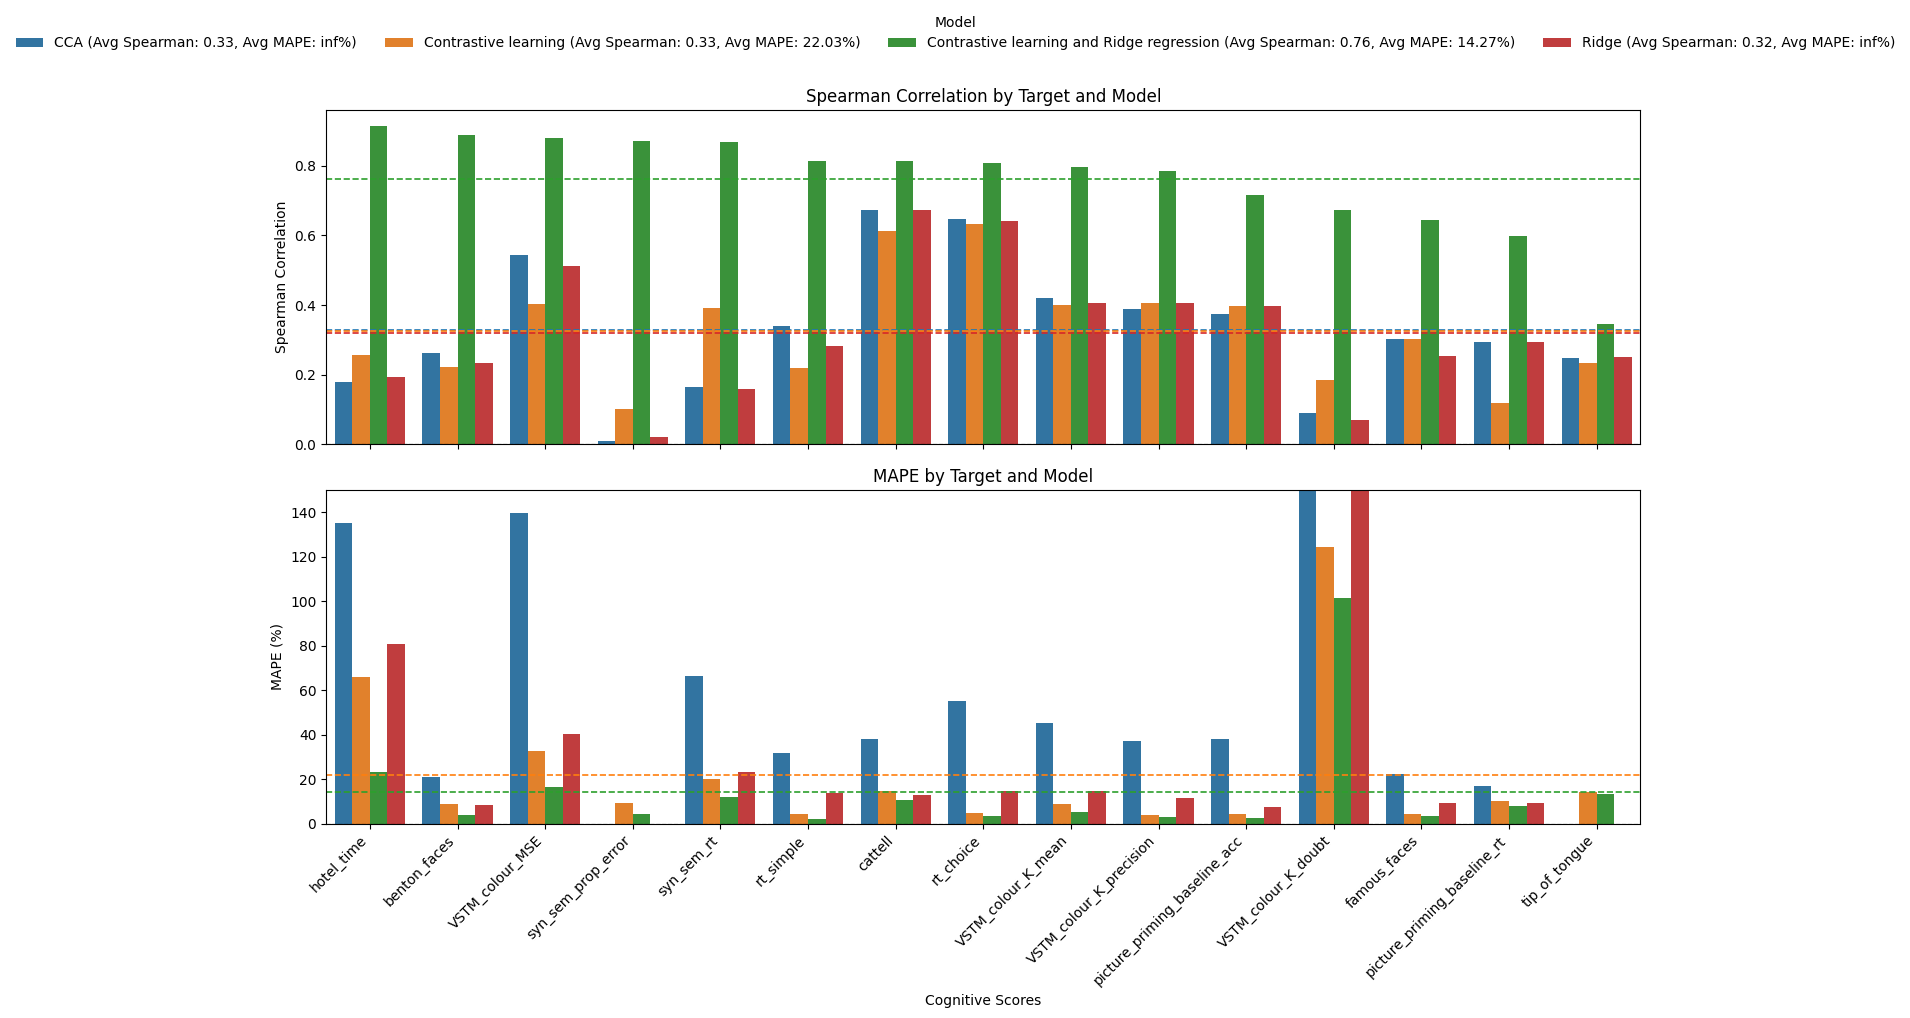

/tmp/ipykernel_2969458/3354203737.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


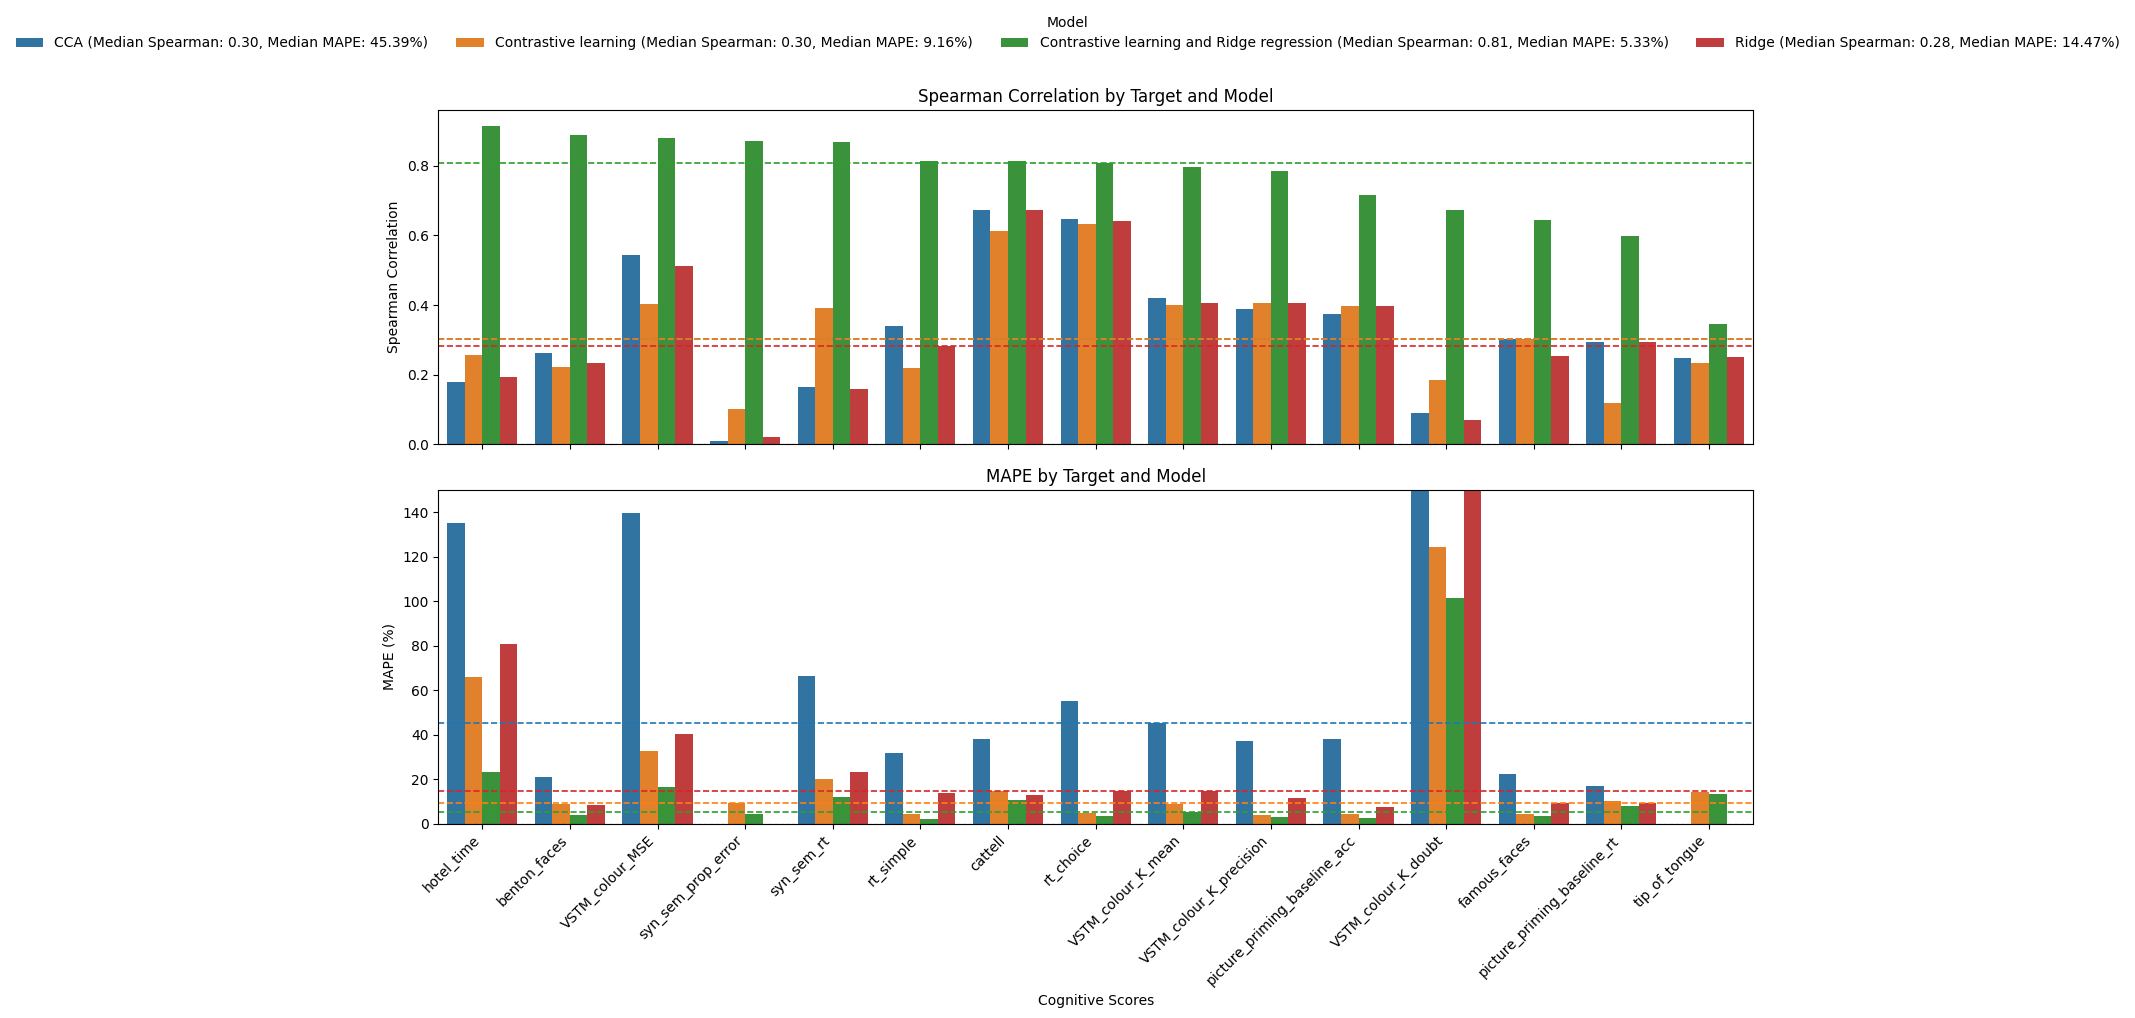

In [80]:
dataset_path = f"{root}/dataset_400parcels_2.nc"

targets = ["age","benton_faces","cardio_measure_pulse_mean","cardio_measure_bp_sys_mean",
            "cardio_measure_bp_dia_mean", "cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

targets_to_plot = ["benton_faces", "cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

X_train, y_train, X_test, y_test = prepare_data(dataset_path, targets)

ridge_whole = ridge_pred(X_train, y_train, X_test, y_test)

cca_whole = cca_pred(X_train, y_train, X_test, y_test)

cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

plot_scores(ridge_whole, cca_whole, cr_pred_whole, targets_to_plot, model_and_ridge)
plot_median_scores(ridge_whole, cca_whole, cr_pred_whole, targets_to_plot, model_and_ridge)

## Residual plots

### Residuals vs true target : for most targets, there is a linear relationship between both, hence the idea for ridge regression on the residuals

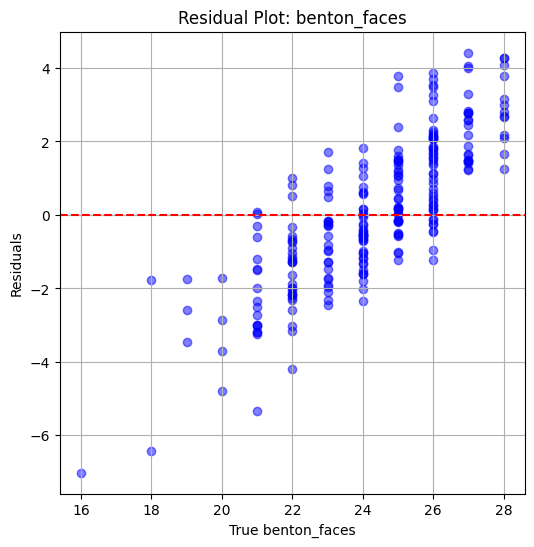

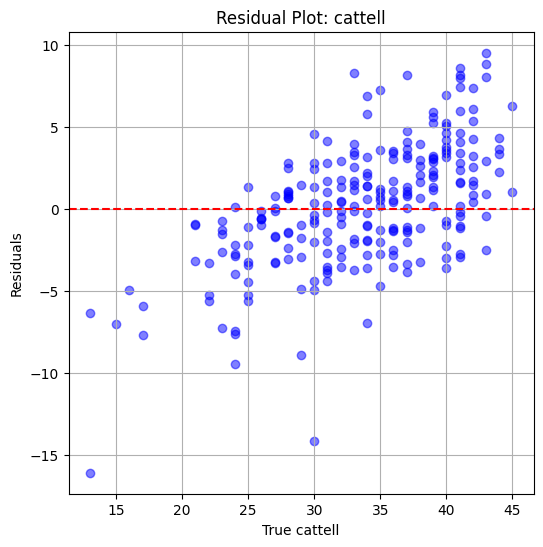

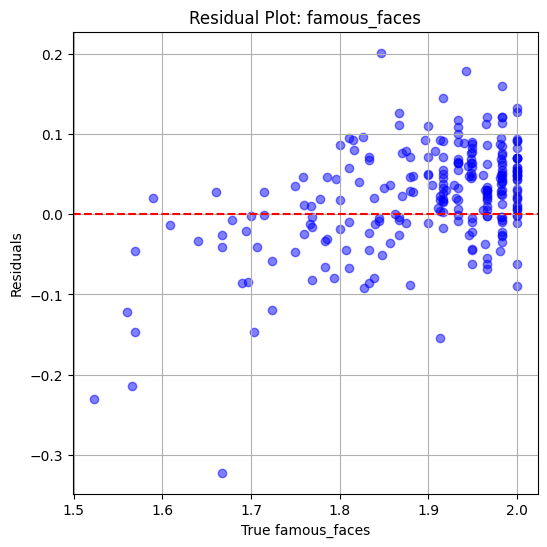

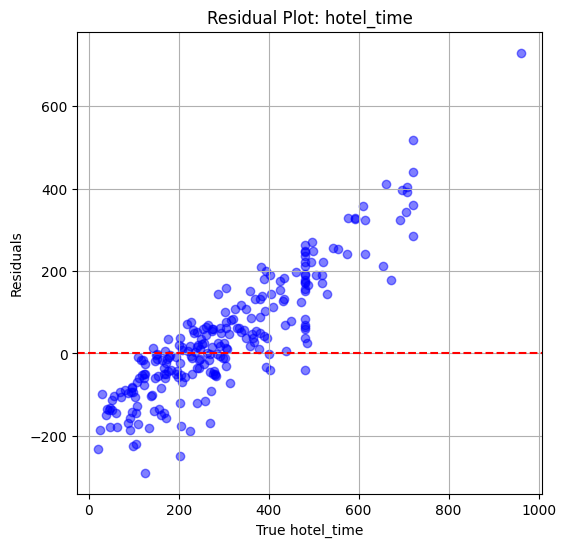

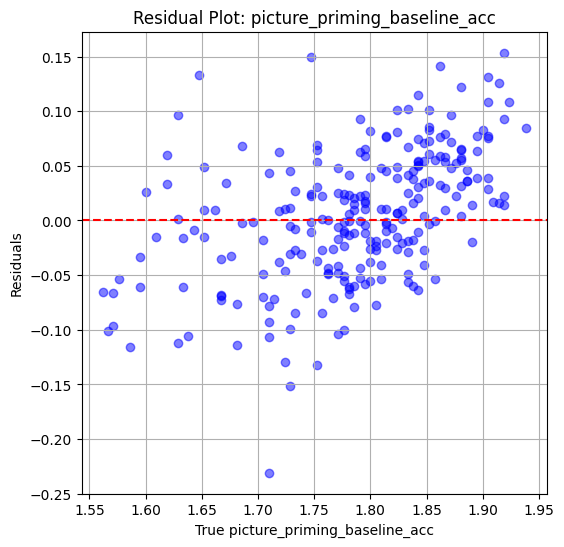

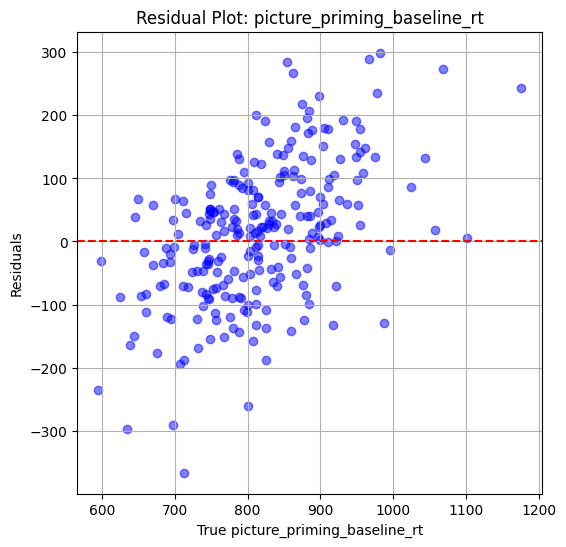

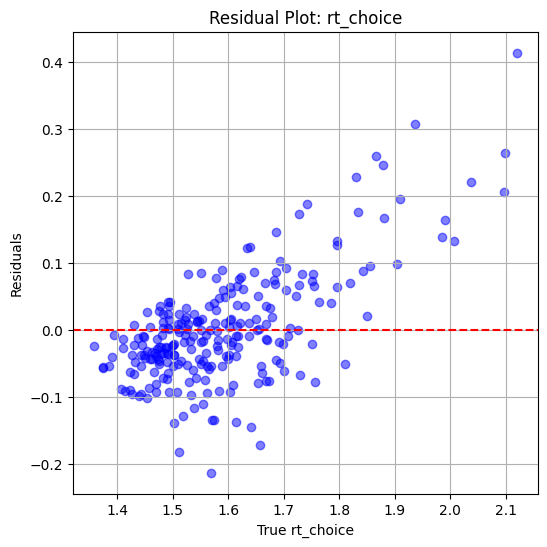

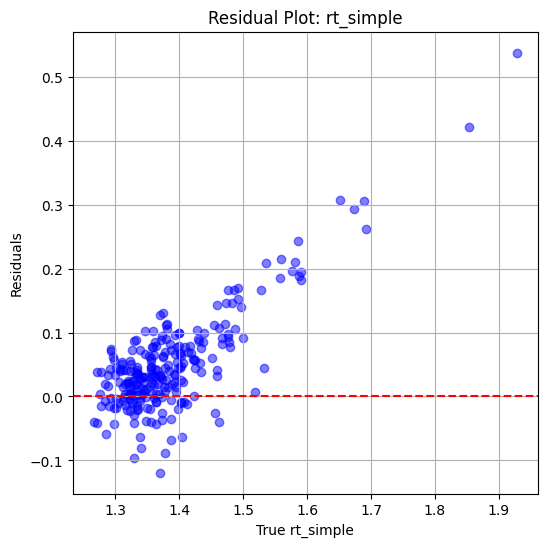

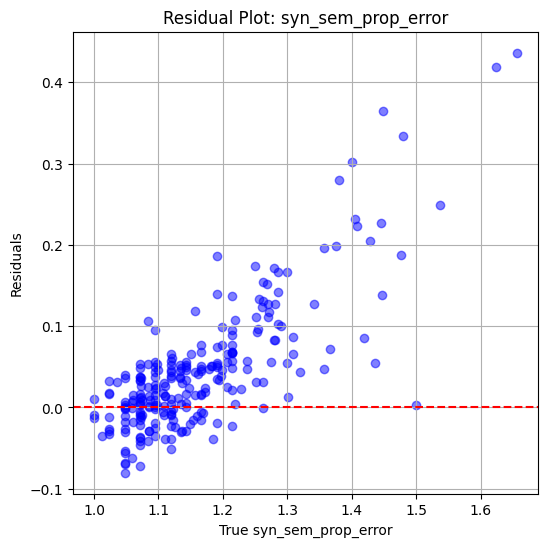

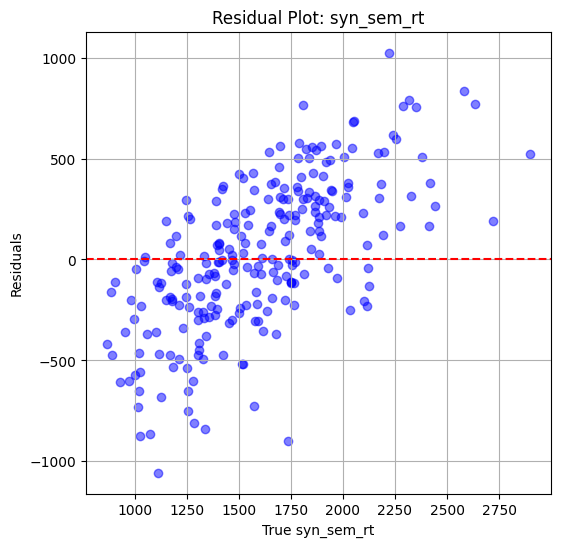

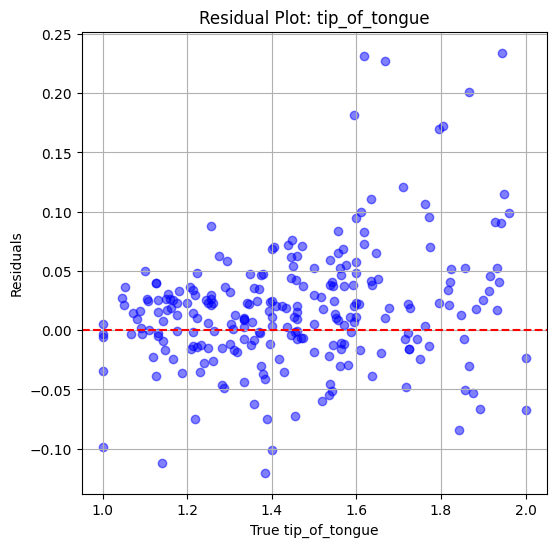

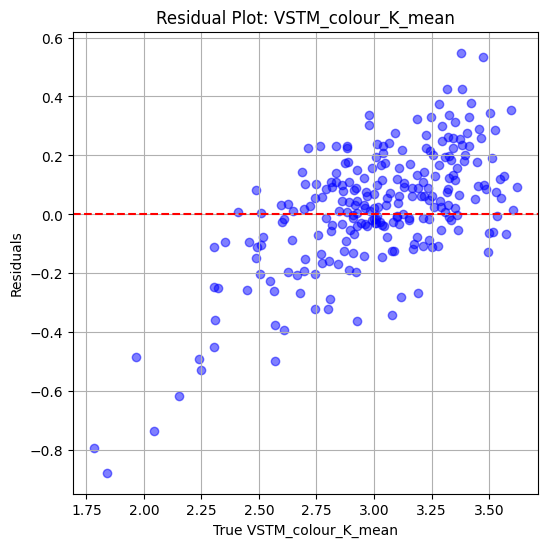

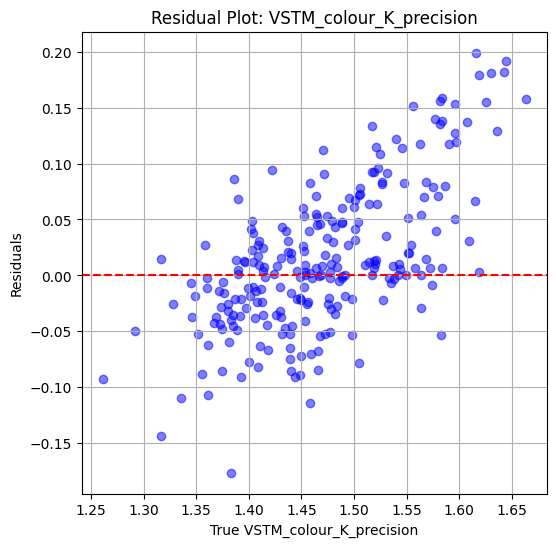

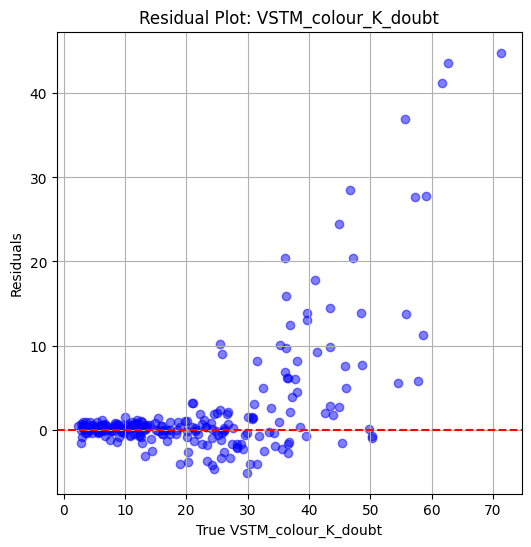

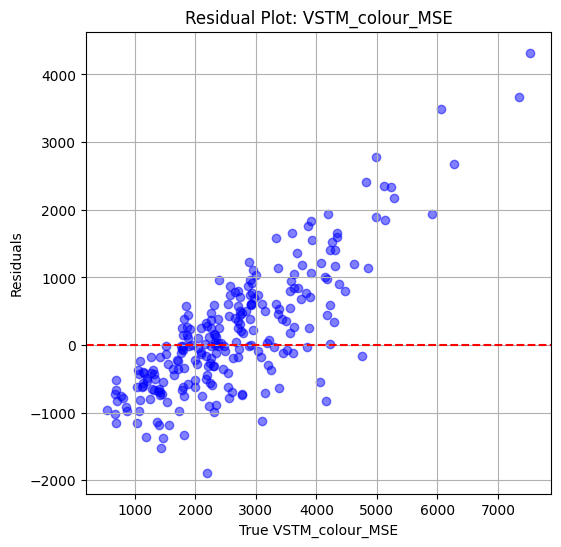

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]

# Ensure columns exist
assert set(target_cols).issubset(cr_pred_whole.columns), "Some target columns are missing."
assert set(pred_cols).issubset(cr_pred_whole.columns), "Some prediction columns are missing."

# Extract original and predicted values for train set
X_train = train_data[pred_cols].values
y_train = train_data[target_cols].values
y_train_pred = X_train  # Assuming the model predictions are stored in the same format as X_train

# Calculate residuals
residuals_train = y_train - y_train_pred  # True values - predicted values

# Plot residuals for each target
for i, target in enumerate(target_cols):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train[:, i], residuals_train[:, i], alpha=0.5, color='b')
    plt.axhline(0, color='red', linestyle='--')  # Horizontal line at y=0 (zero residuals)
    plt.title(f'Residual Plot: {target}')
    plt.xlabel(f'True {target}')
    plt.ylabel(f'Residuals')
    plt.grid(True)
    plt.show()


### Residuals vs predicted targets : relationship is harder to define

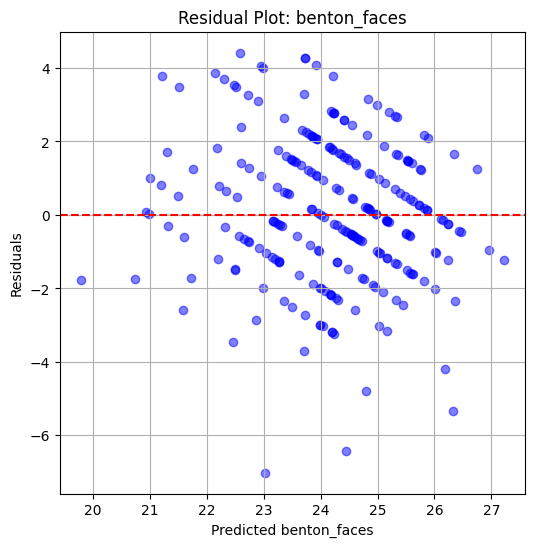

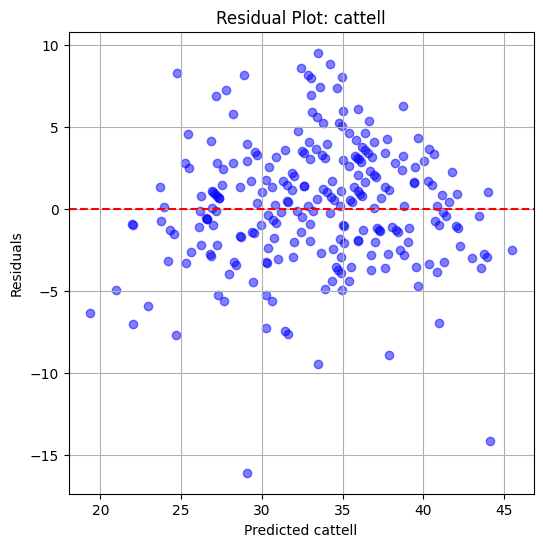

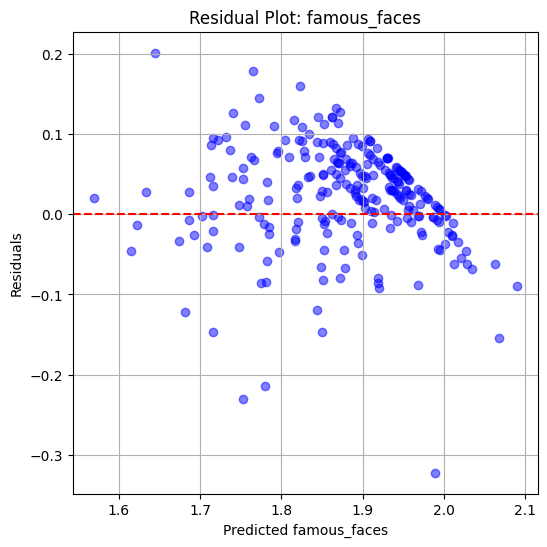

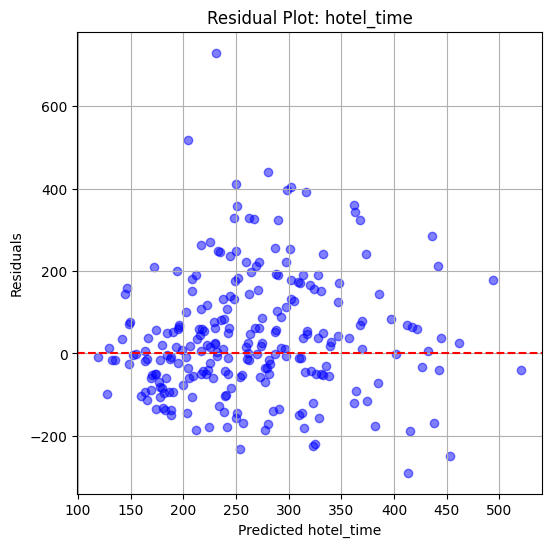

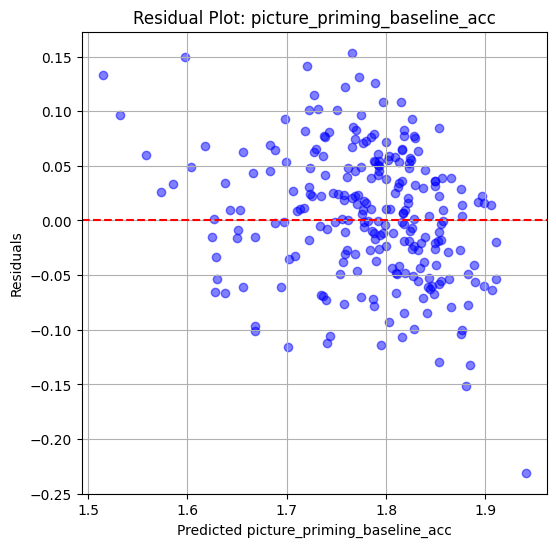

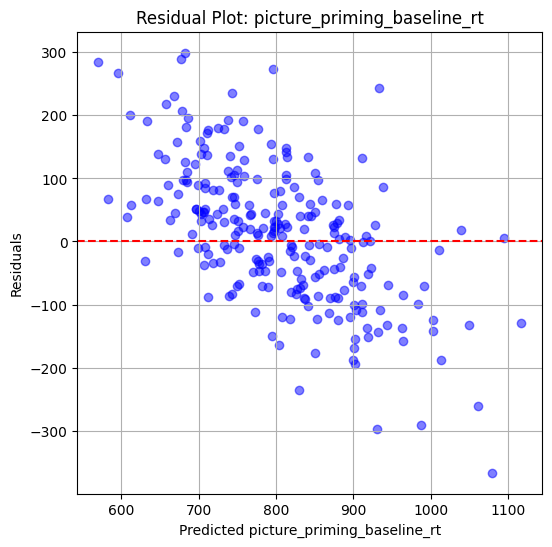

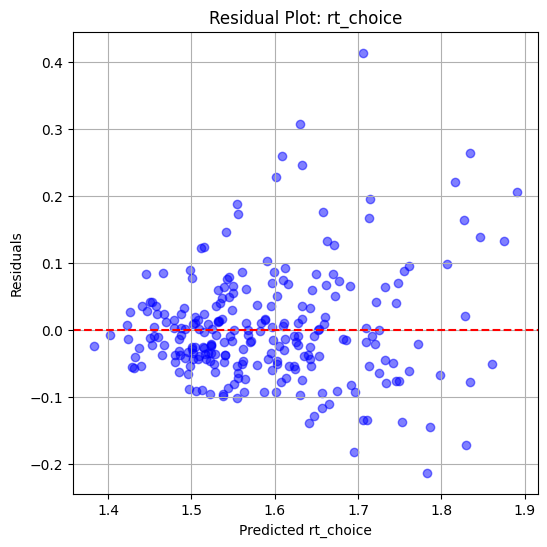

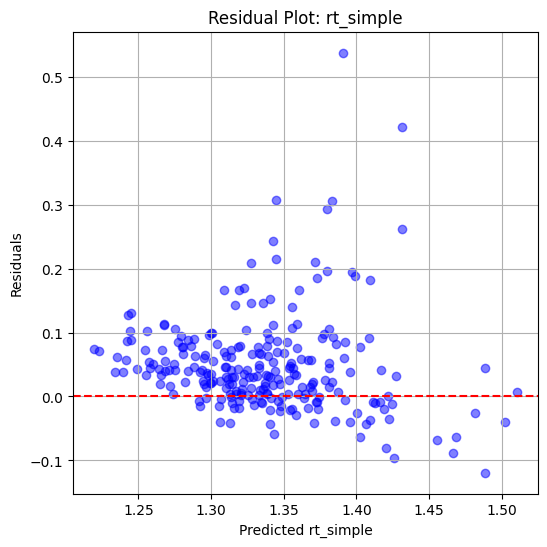

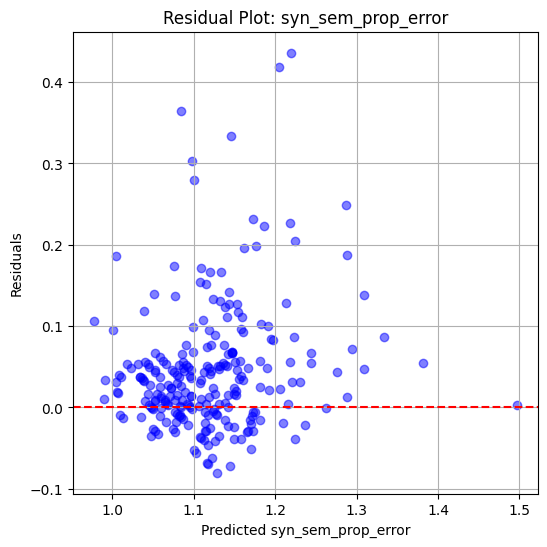

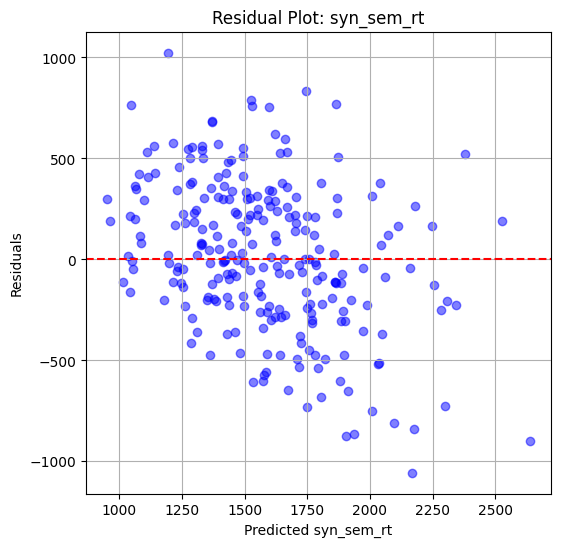

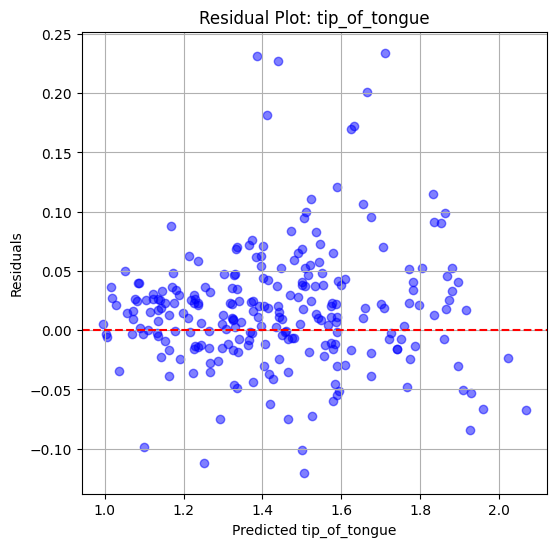

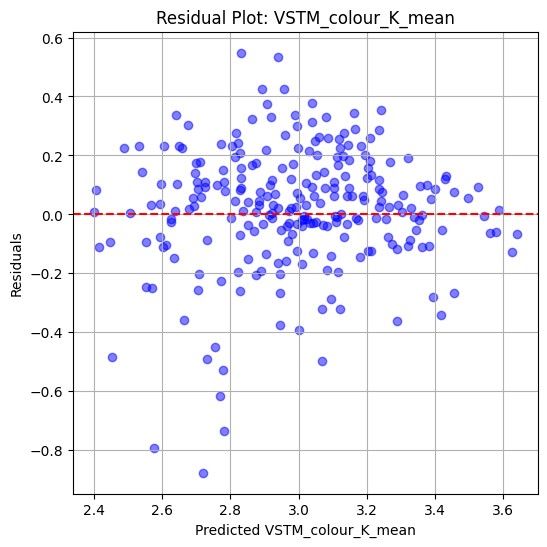

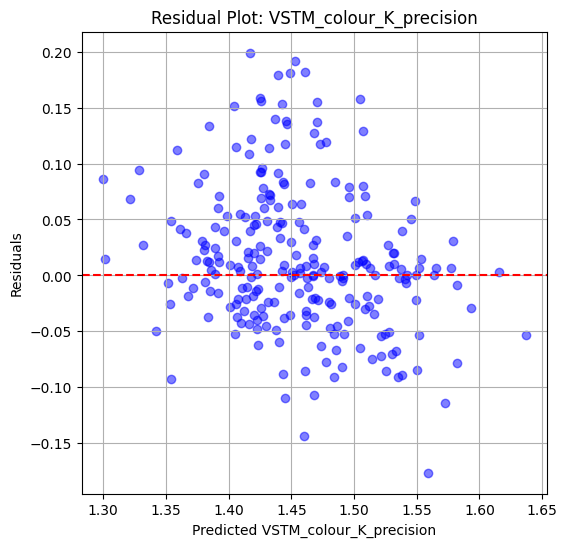

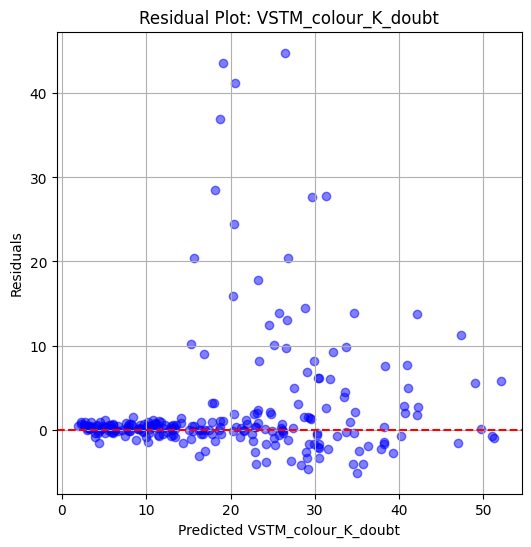

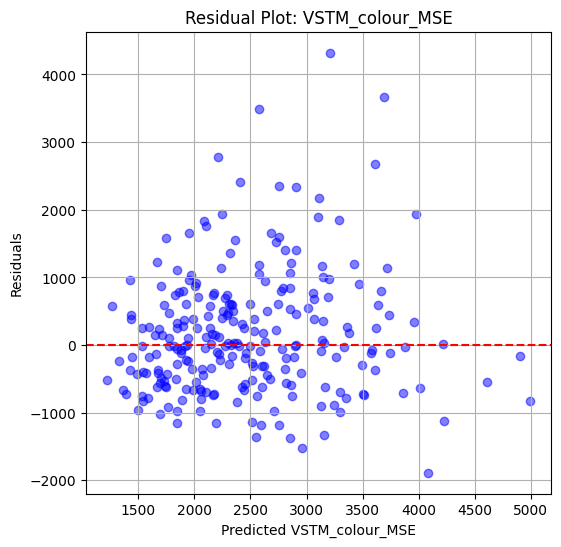

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]

# Ensure columns exist
assert set(target_cols).issubset(cr_pred_whole.columns), "Some target columns are missing."
assert set(pred_cols).issubset(cr_pred_whole.columns), "Some prediction columns are missing."

# Extract original and predicted values for train set
X_train = train_data[pred_cols].values
y_train = train_data[target_cols].values
y_train_pred = X_train  # Assuming the model predictions are stored in the same format as X_train

# Calculate residuals
residuals_train = y_train - y_train_pred  # True values - predicted values

# Plot residuals for each target
for i, target in enumerate(target_cols):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train_pred[:, i], residuals_train[:, i], alpha=0.5, color='b')
    plt.axhline(0, color='red', linestyle='--')  # Horizontal line at y=0 (zero residuals)
    plt.title(f'Residual Plot: {target}')
    plt.xlabel(f'Predicted {target}')
    plt.ylabel(f'Residuals')
    plt.grid(True)
    plt.show()


### True vs predicted 

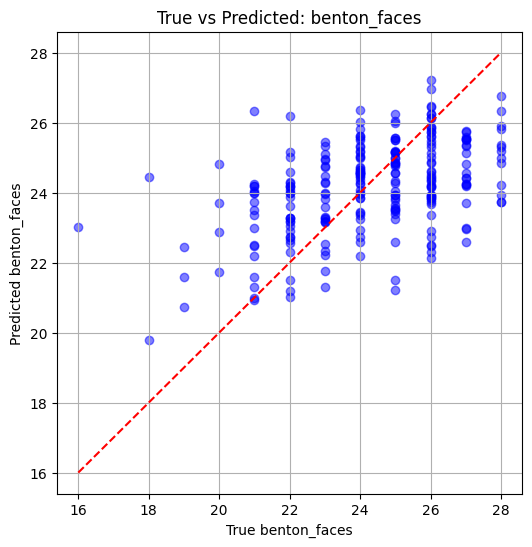

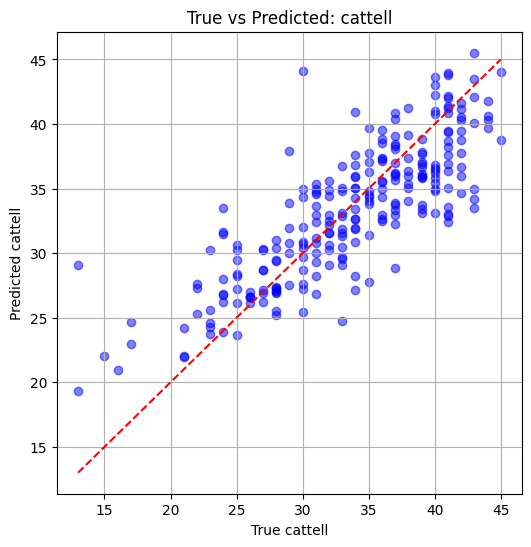

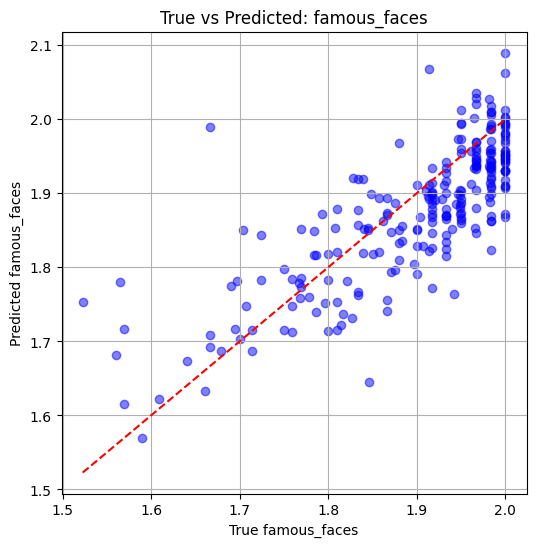

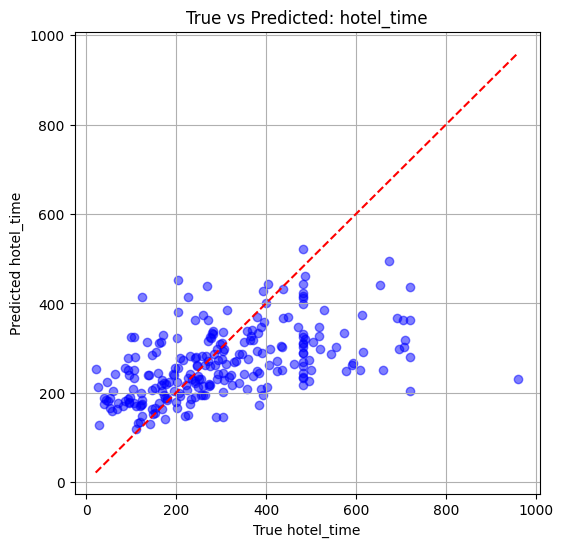

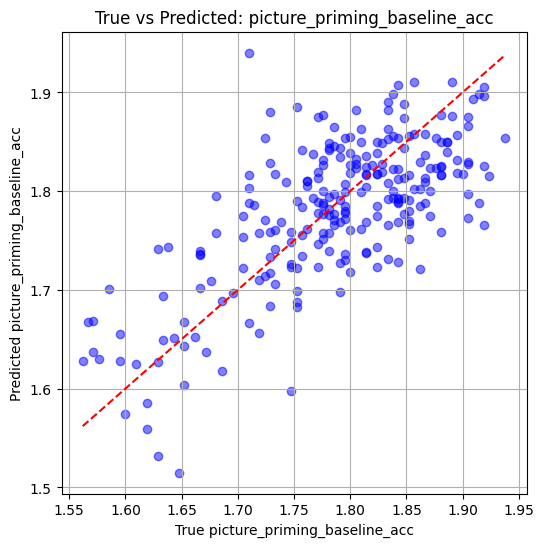

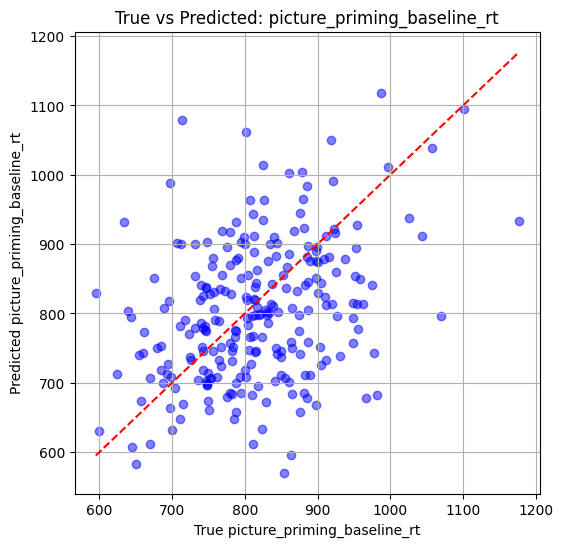

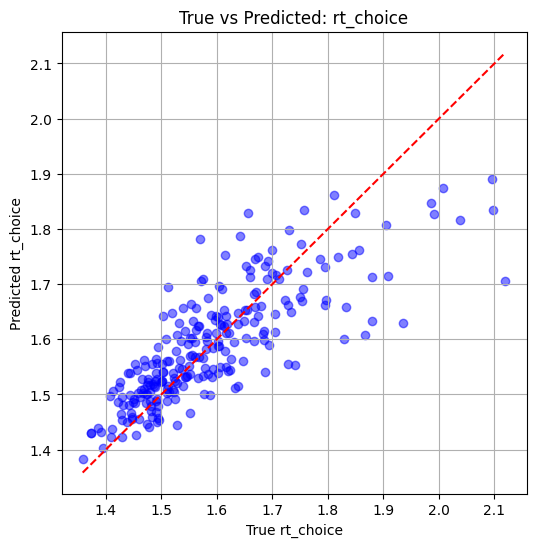

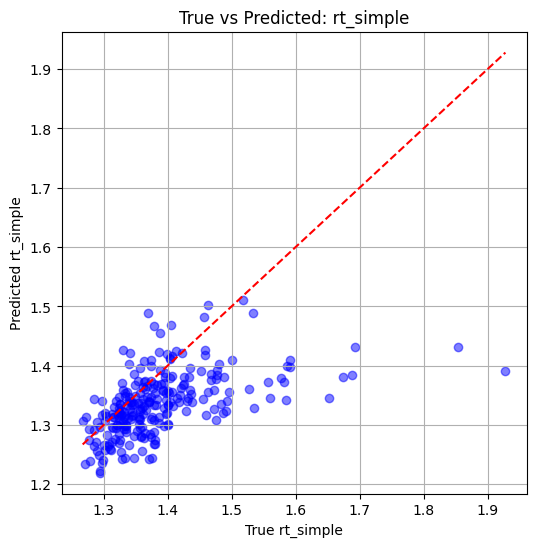

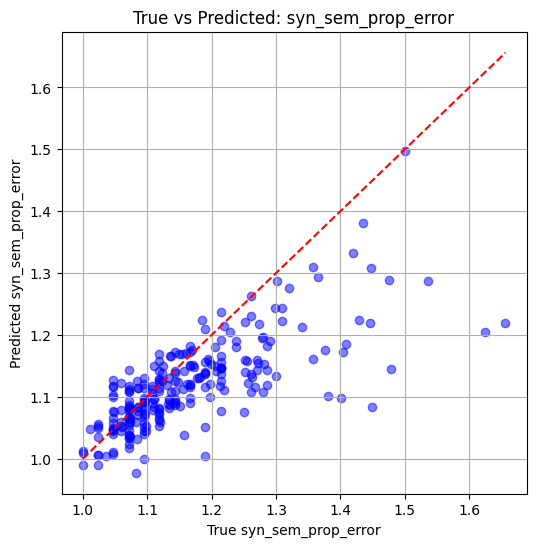

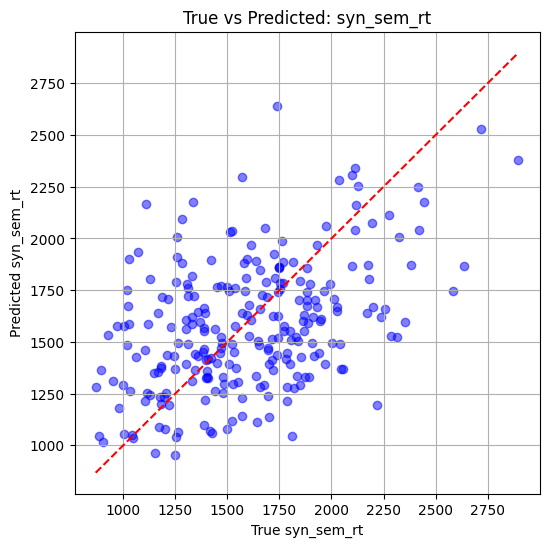

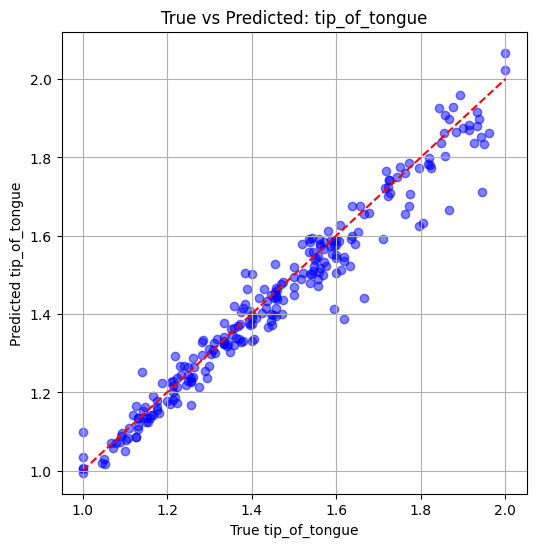

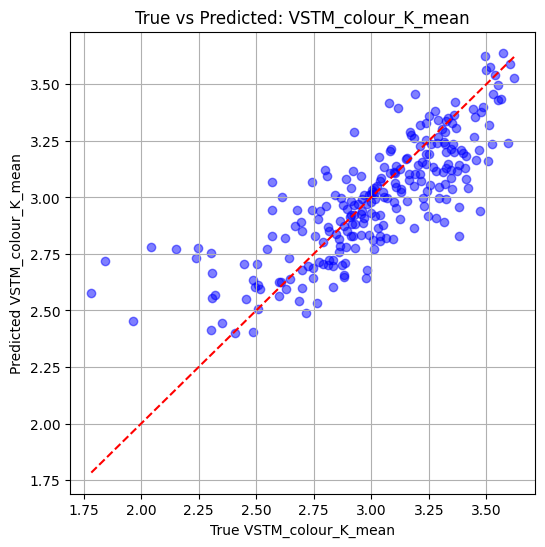

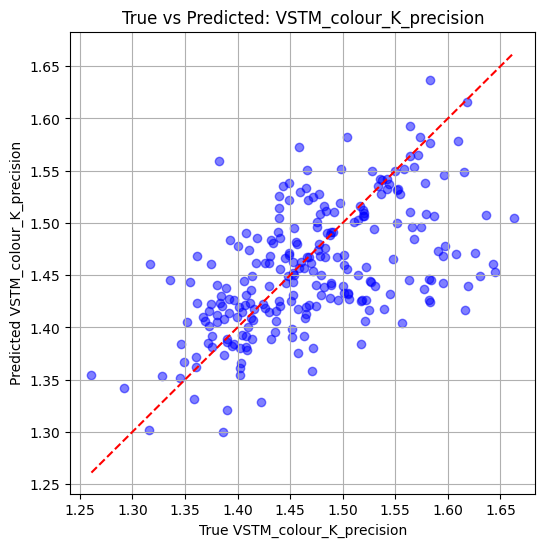

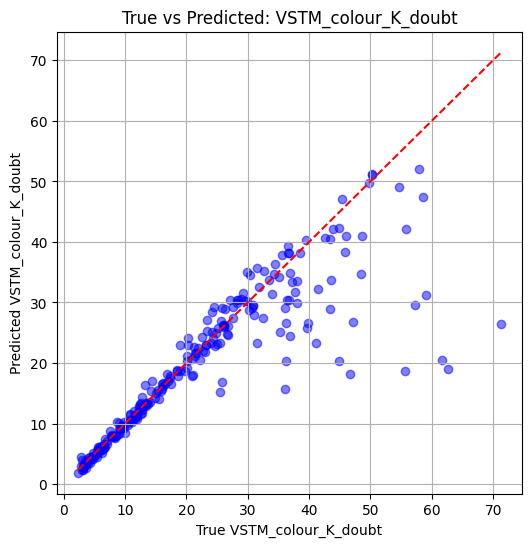

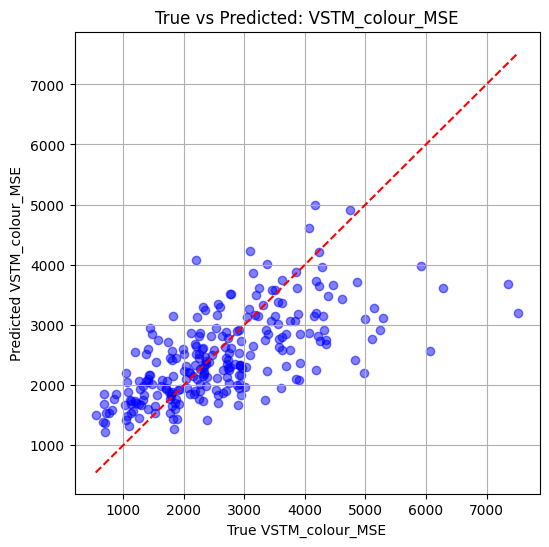

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]

# Ensure columns exist
assert set(target_cols).issubset(cr_pred_whole.columns), "Some target columns are missing."
assert set(pred_cols).issubset(cr_pred_whole.columns), "Some prediction columns are missing."

# Extract original and predicted values for train set
X_train = train_data[pred_cols].values
y_train = train_data[target_cols].values

# Plot true vs predicted values for each target
for i, target in enumerate(target_cols):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train[:, i], X_train[:, i], alpha=0.5, color='b')
    plt.plot([y_train[:, i].min(), y_train[:, i].max()], [y_train[:, i].min(), y_train[:, i].max()], color='red', linestyle='--')  # Line for perfect predictions
    plt.title(f'True vs Predicted: {target}')
    plt.xlabel(f'True {target}')
    plt.ylabel(f'Predicted {target}')
    plt.grid(True)
    plt.show()


## Comparisons with different sample sizes

In [ ]:
#Contrastive learning prediction results
cr_pred_100 = pd.read_csv("results/final model 100 samples/pred_results.csv")
cr_pred_200 = pd.read_csv("results/final model 200 samples/pred_results.csv")
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

### 100 samples

/tmp/ipykernel_767230/313208744.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


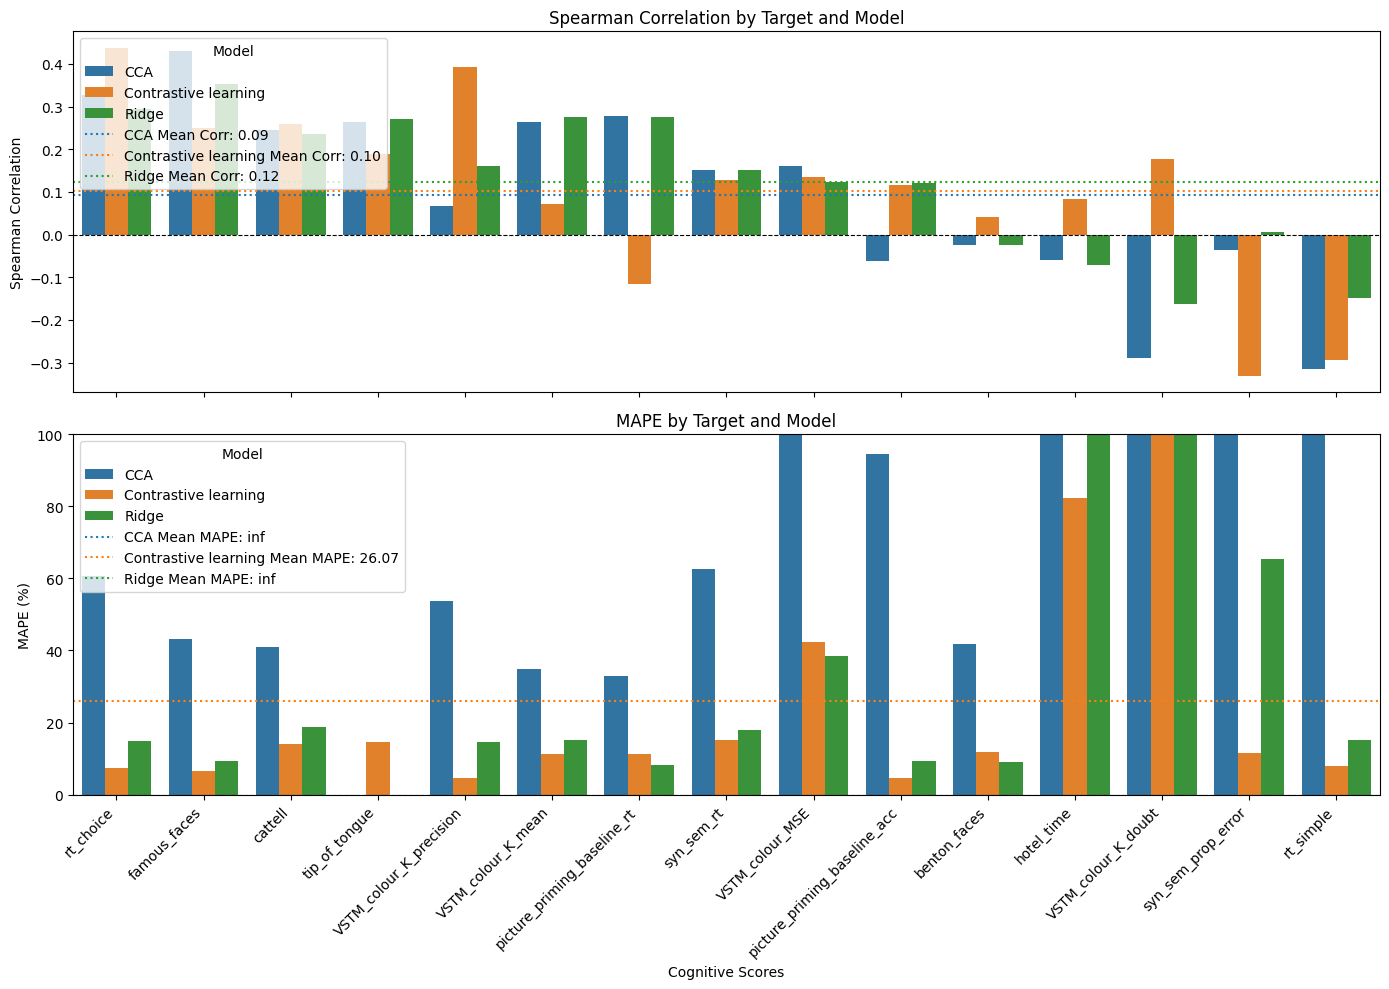

In [42]:
dataset_path = f"{root}/new_dataset_100_subjects.nc"

targets = ["benton_faces","cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

X_train, y_train, X_test, y_test = prepare_data(dataset_path, targets)

ridge_100 = ridge_pred(X_train, y_train, X_test, y_test)

cca_100 = cca_pred(X_train, y_train, X_test, y_test)

cr_pred_100 = pd.read_csv("results/final model 100 samples/pred_results.csv")

plot_scores(ridge_100, cca_100, cr_pred_100, targets)


/tmp/ipykernel_767230/1003462680.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


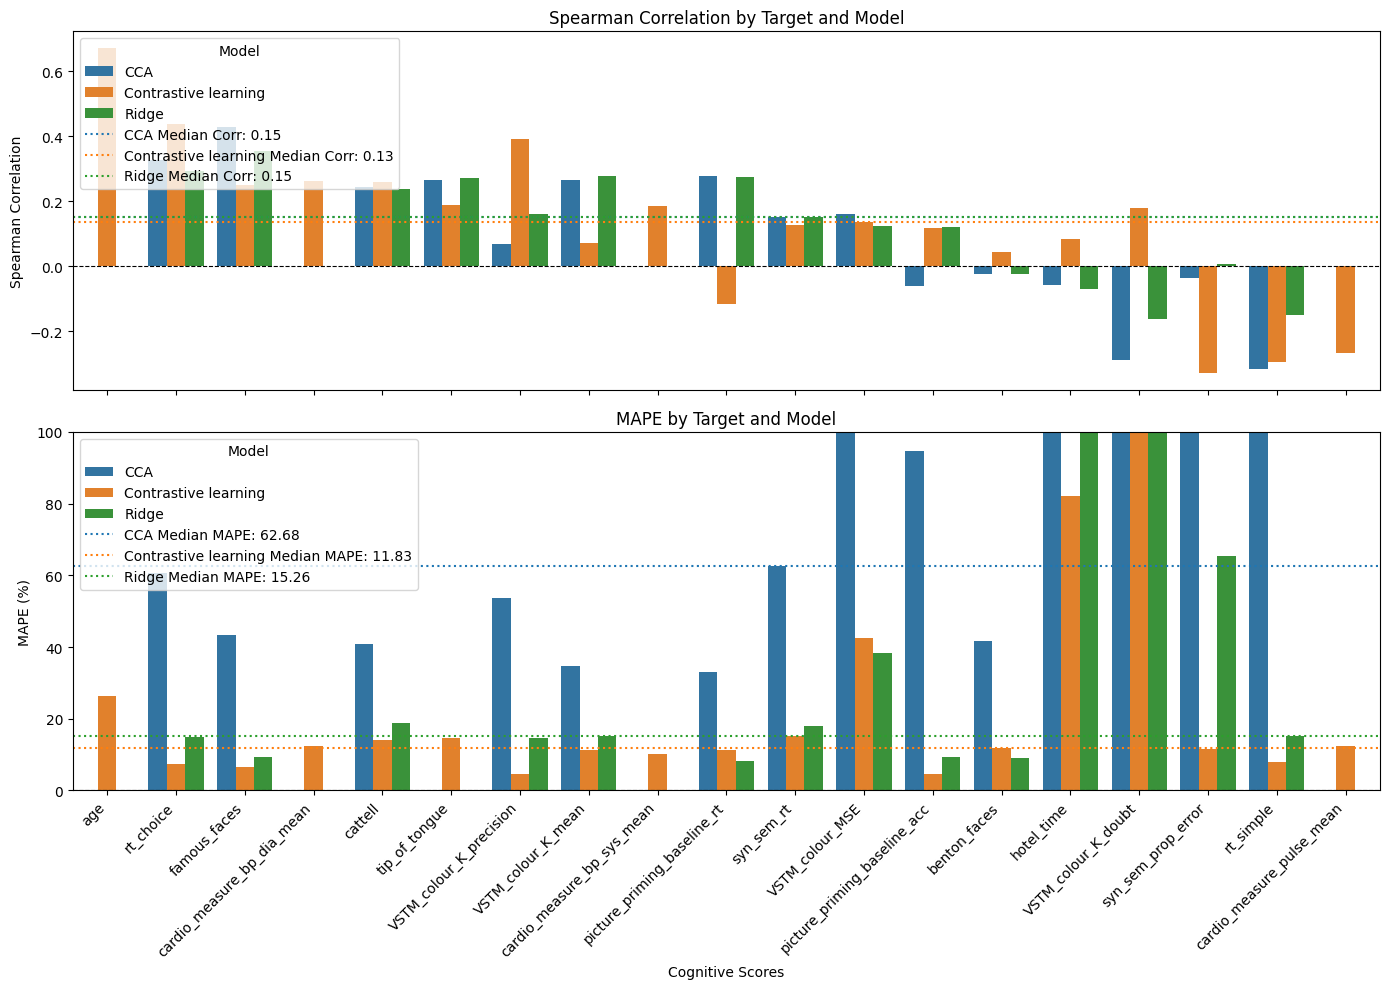

In [48]:
plot_median_scores(ridge_100, cca_100, cr_pred_100, targets)


### 200 samples

/tmp/ipykernel_2969458/313208744.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


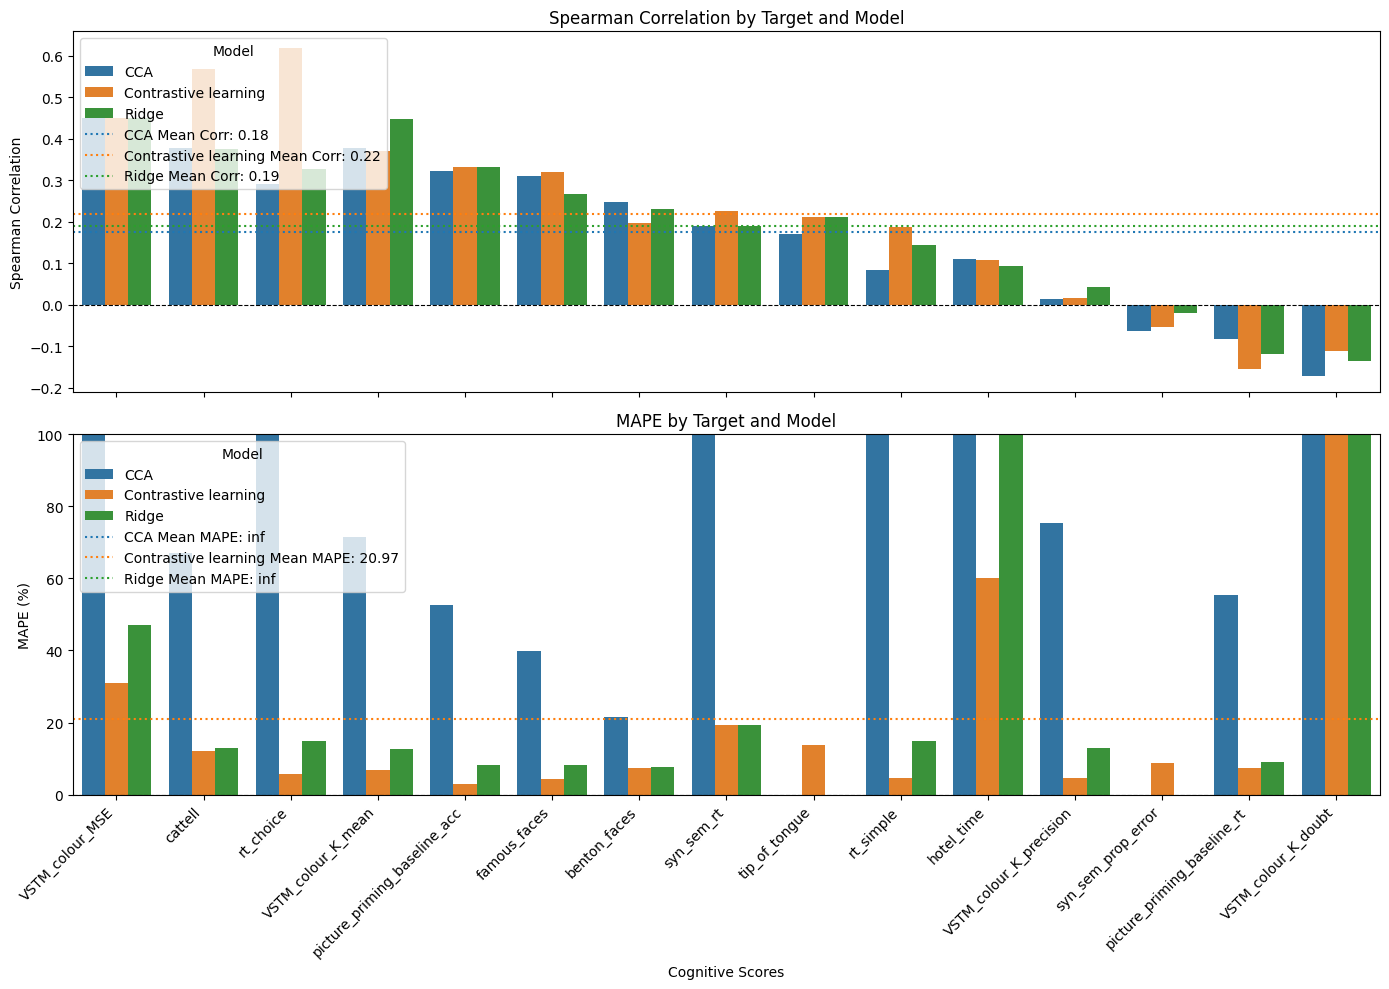

In [21]:
dataset_path = f"{root}/new_dataset_200_subjects.nc"

targets = ["benton_faces","cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

X_train, y_train, X_test, y_test = prepare_data(dataset_path, targets)

ridge_200 = ridge_pred(X_train, y_train, X_test, y_test)

cca_200 = cca_pred(X_train, y_train, X_test, y_test)

cr_pred_200 = pd.read_csv("results/final model 200 samples/pred_results.csv")

plot_scores(ridge_200, cca_200, cr_pred_200, targets)

/tmp/ipykernel_2969458/1003462680.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


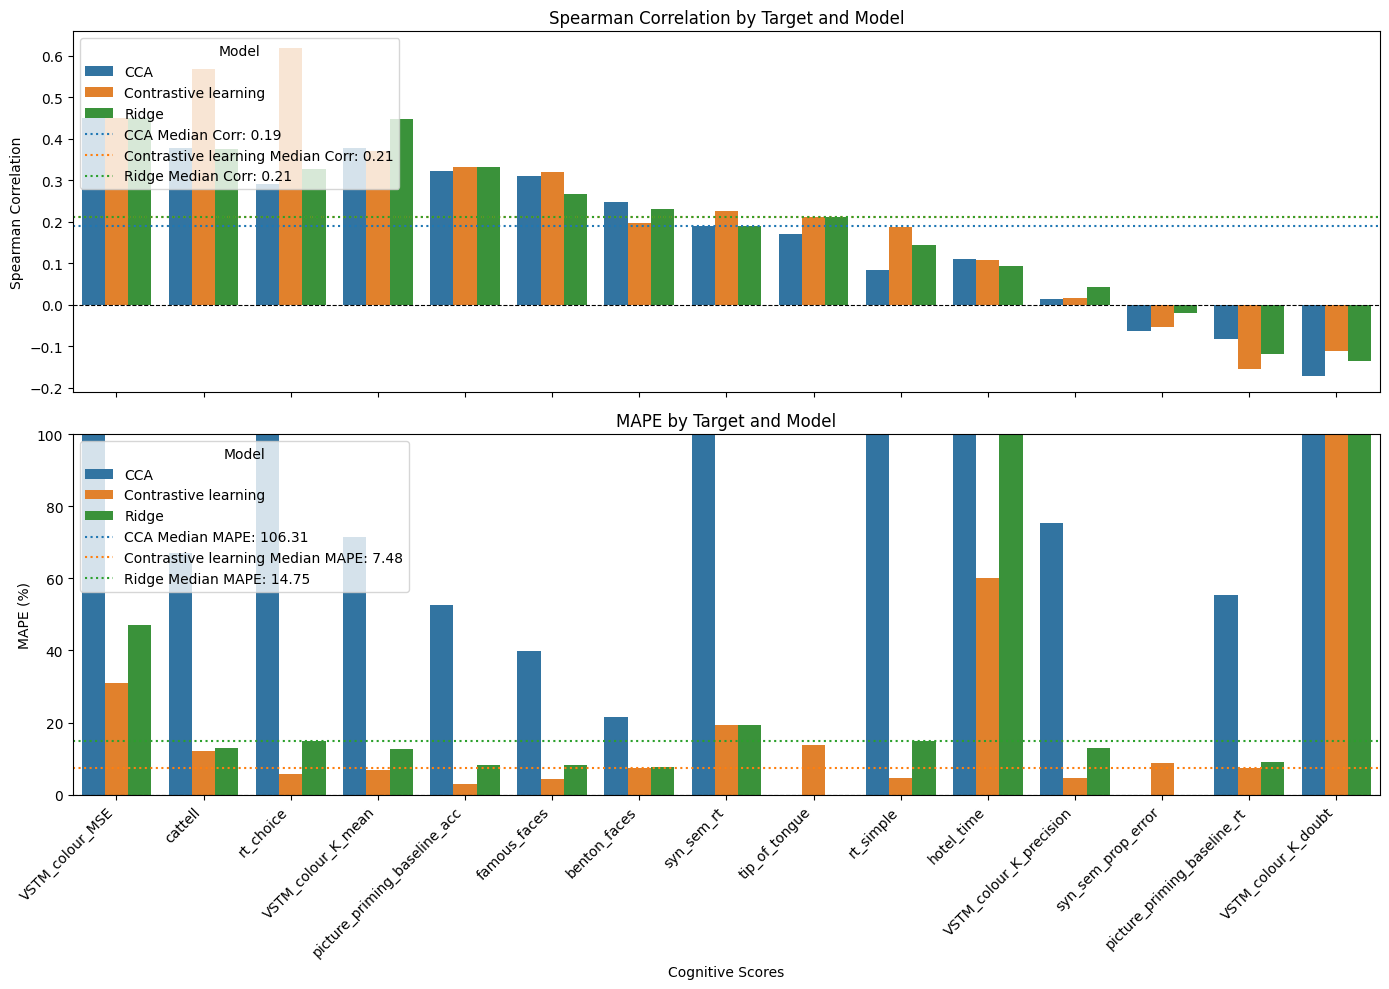

In [22]:
plot_median_scores(ridge_200, cca_200, cr_pred_200, targets)